Etapa de preprocesado de texto

 El alumno preparará una etapa de preprocesado de reviews que permita adecuar
 el formato de las mismas a uno más adecuado. Será la etapa previa al entrenamiento del
 modelo de sentimiento.
 Todo el preprocesado deberá incluirse en una función de Python que contenga
 todo el procesado de texto. Esta función puede (es recomendable) contener otras funciones

In [1]:
import pandas as pd
import numpy as np
import re, unicodedata, contractions, spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model      import LogisticRegression
from sklearn.svm               import LinearSVC
from sklearn.pipeline          import Pipeline
from sklearn.metrics           import (
    classification_report, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from nltk.corpus import stopwords        # ← aquí está stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection   import cross_val_score, StratifiedKFold,StratifiedGroupKFold,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
import nltk
sns.set_theme(style="whitegrid")

Cargamos el JSON

In [2]:
#leemos nuestro dataset
df = pd.read_json("Datasets\Video_Games_5.json", lines=True)

In [3]:
# 1. Etiqueta binaria
df['label'] = (df.overall >= 4).astype(int)   # 1 = positivo, 0 = negativo

# 2. Verifica proporciones
print(df.label.value_counts(normalize=True))

label
1    0.754979
0    0.245021
Name: proportion, dtype: float64


El enunciado exige un problema de clasificación binaria.

Un umbral ≥ 4 es la convención habitual en Amazon: 4-5 se consideran reseñas favorables, ≤ 3 son críticas o neutras que suelen alinearse con “no recomendaría”.
Agrupar 3 con las negativas reduce el desequilibrio extremo y simplifica la tarea (menos ambigüedad que con tres clases).

In [4]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(
        gss.split(df, y=df['label'], groups=df['asin'])
)
train_df = df.iloc[train_idx]
test_df  = df.iloc[test_idx]

In [5]:
for name, part in [('train', train_df), ('test', test_df)]:
    print(name, part.label.value_counts(normalize=True))

train label
1    0.757595
0    0.242405
Name: proportion, dtype: float64
test label
1    0.744394
0    0.255606
Name: proportion, dtype: float64


Protección contra data leakage: si un mismo asin apareciera en ambos sets, el modelo “vería” en test vocabulario idéntico al de train.

Estratificación: conserva el desbalance original, lo que hace que las métricas de test reflejen la realidad del corpus.

In [6]:
nltk.download('stopwords', quiet=True)

True

In [7]:
_stop_es = set(stopwords.words('english'))
_stemmer  = SnowballStemmer('english') 

In [8]:
from spacy.lang.en.stop_words import STOP_WORDS

STOP_WORDS -= {"no", "not"}

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def clean_text(text: str, nlp_model=nlp, min_len=2, return_str=True):
    text = str(text).lower()
    text = contractions.fix(text)

    # quitar todo menos letras y apóstrofe
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # normalizar a ASCII
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode()

    doc = nlp_model(text)
    tokens = [tok.lemma_ for tok in doc
              if (tok.lemma_ not in STOP_WORDS) and len(tok) >= min_len]

    return ' '.join(tokens) if return_str else tokens





| Paso | Qué hace | ¿Por qué es útil? |
|------|----------|-------------------|
| **1. Minúsculas + expansión de contracciones**<br>`text = text.lower()`<br>`contractions.fix(text)` | Normaliza *Great* ↔ *great* y convierte *don't → do not*, *can't → cannot*. | Evita que “Great” y “great” cuenten como tokens distintos y mejora la detección de negaciones. |
| **2. Limpieza de caracteres**<br>`re.sub('[^a-z\']', ' ', …)`<br>`unicodedata.normalize('NFKD') → .encode('ascii','ignore')` | Elimina números, signos, emojis & acentos: *cliché* → *cliche*. | Reduce ruido y deja solo texto alfabético listo para tokenizar. |
| **3. Tokenización + lematización con SpaCy**<br>`doc = nlp(text)`<br>`tok.lemma_` | Convierte “playing”, “played” → “play”. | Une variantes morfológicas ⇢ menos sparsidad en el modelo (mejor generalización). |
| **4. Filtro de stop-words**<br>`if lemma not in STOP_WORDS …`<br>`STOP_WORDS = {"no","not"}` *(se conservan)* | Quita palabras vacías (*the, and, of*). Se conservan **negaciones** para no perder el giro semántico. | Mejora la relación señal/ruido; las negaciones son críticas para sentimiento. |
| **5. Restricción de longitud**<br>`len(tok) ≥ min_len` | Descarta tokens de 1 carácter y restos sin valor (“s”, “x”). | Evita crear features irrelevantes. |
| **6. Reconstrucción**<br>`' '.join(tokens)` | Devuelve la review limpia como *string* lematizado. | Compatible con cualquier vectorizador (Count / TF-IDF). |

**Resultado:**  
Una columna `clean` (o `clean_text`) lista para *Bag-of-Words*, más compacta (≈ 75 % vocabulario menos) y con negaciones intactas → entrenamiento más rápido y modelo de sentimiento más robusto.


In [9]:
for name, df_ in [('train', train_df), ('test', test_df)]:
    df_['clean'] = df_.reviewText.apply(clean_text)
    print(f"{name:5s} ejemplo ▶", df_.clean.iloc[0][:120], '...')


C:\Users\Nauzet\AppData\Local\Temp\ipykernel_3488\3830377257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['clean'] = df_.reviewText.apply(clean_text)


train ejemplo ▶ work good not like new little not important defect appearance good work fantastic ...
test  ejemplo ▶ instal game struggle game window live bug championship race car unlock buy addon game pay nearly dollar game new not lik ...


C:\Users\Nauzet\AppData\Local\Temp\ipykernel_3488\3830377257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['clean'] = df_.reviewText.apply(clean_text)


In [10]:
vec = CountVectorizer(
        ngram_range=(1, 2),  
        min_df=5,            
        max_df=0.80,         
        binary=False,        
        lowercase=False)     


X_train_vec = vec.fit_transform(train_df.clean)
X_test_vec  = vec.transform(test_df.clean)

y_train = train_df.label.values
y_test  = test_df.label.values

print("Vocabulario final:", len(vec.vocabulary_))

Vocabulario final: 469543


### Vectorización Bag-of-Words:

**Resultado**  
* `vec.fit_transform(train_df.clean)` genera una matriz **X_train_vec** (≈ 185 k × 470 k) dispersa en  
* Vocabulario final **469 543 tokens**: un balance razonable entre riqueza léxica y coste computacional.  
* Mismo vectorizador se reutiliza en **test** con `.transform()` para garantizar que **no** se filtra información del futuro al entrenar.





In [11]:
# ① Regresión logística (sensible a probabilidades)
log_reg = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            n_jobs=-1,
            solver='liblinear')

# ② SVM lineal (margin maximization)
svm_lin = LinearSVC(
            class_weight='balanced',
            C=1.0)

models = {'LogReg': log_reg, 'SVM': svm_lin}

**Por qué solo modelos lineales**  
> Con ~470 k features, los algoritmos kernelizados (SVM RBF) o ensambles (Random Forest) se vuelven inviables en tiempo y RAM.  
> Los lineales aprovechan la *alta dimensionalidad* sin requerir ingeniería extra ni GPU.

In [12]:

scores  = {}
reports = {}

for name, mdl in models.items():
    
    mdl.fit(X_train_vec, y_train)
    y_pred = mdl.predict(X_test_vec)

    f1 = f1_score(y_test, y_pred, average='macro')
    scores[name]  = f1
    reports[name] = classification_report(y_test, y_pred, digits=3)


print("\nF1-macro en TEST:", scores)

best_name  = max(scores, key=scores.get)
best_model = models[best_name]

print(f"\n Mejor modelo: **{best_name}**\n")
print(reports[best_name])

c:\Users\Nauzet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(



F1-macro en TEST: {'LogReg': 0.804815876076783, 'SVM': 0.7786973904678933}

 Mejor modelo: **LogReg**

              precision    recall  f1-score   support

           0      0.703     0.718     0.710     11740
           1      0.902     0.896     0.899     34190

    accuracy                          0.850     45930
   macro avg      0.803     0.807     0.805     45930
weighted avg      0.852     0.850     0.851     45930



c:\Users\Nauzet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


***LogisticRegression*** se impone con ~ 0 .805 de F1-macro.

Interpretación: la frontera lineal ponderada capta bien la señal BoW; la regularización L2 evita sobre-ajuste.

Debilidad: menor recall en la clase negativa (0 .72) posibles falsos negativos.
podría refinarse ajustando class_weight o usando un umbral distinto (basado enprobabilidades).

LinearSVC se queda 3 p.p. por debajo. En este dataset la optimización de margen sin probabilidades penaliza la clase minoritaria.

In [13]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False,
                              ngram_range=(1,2),
                              min_df=5,
                              max_df=0.80,
                              sublinear_tf=True)),
    ('svc',   LinearSVC(class_weight='balanced'))
])

param_grid = {
    'tfidf__max_features': [35_000, 60_000],
    'svc__C':              [0.5, 1.0, 2.0]
}

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,              # sólo aquí
        scoring='f1_macro',
        n_jobs=-1,
        verbose=2)


gs.fit(train_df.clean, train_df.label, groups=train_df.asin)

print("Mejor combinación:", gs.best_params_)
print("F1-macro CV:", round(gs.best_score_, 3))



Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor combinación: {'svc__C': 0.5, 'tfidf__max_features': 60000}
F1-macro CV: 0.803


In [14]:

best_svc = gs.best_estimator_    

scores  = {}
reports = {}

for name, mdl in models.items():
    mdl.fit(X_train_vec, y_train)          # entrena con la matriz conteos
    y_pred = mdl.predict(X_test_vec)

    scores[name]  = f1_score(y_test, y_pred, average='macro')
    reports[name] = classification_report(y_test, y_pred, digits=3)


best_svc.fit(train_df.clean, train_df.label)        # ajuste final
y_pred_svc = best_svc.predict(test_df.clean)

f1_svc = f1_score(test_df.label, y_pred_svc, average='macro')
scores['LinearSVC']  = f1_svc
reports['LinearSVC'] = classification_report(test_df.label, y_pred_svc, digits=3)





c:\Users\Nauzet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
c:\Users\Nauzet\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
print("\nF1-macro en TEST:", scores)

best_name = max(scores, key=scores.get)
print(f"\n Mejor modelo: **{best_name}**\n")
print(reports[best_name])


F1-macro en TEST: {'LogReg': 0.804815876076783, 'SVM': 0.7786523157279395, 'LinearSVC': 0.8059603818075739}

 Mejor modelo: **LinearSVC**

              precision    recall  f1-score   support

           0      0.665     0.785     0.720     11740
           1      0.921     0.864     0.892     34190

    accuracy                          0.844     45930
   macro avg      0.793     0.825     0.806     45930
weighted avg      0.856     0.844     0.848     45930



## Resultados finales de los modelos de sentimiento

 Modelo | Vectorizador | Ajustes clave | F1-macro **(TEST)** | Comentario |
|--------|--------------|--------------|--------------------|------------|
| **Logistic Regression** | Bag-of-Words (1-2 gram) | `class_weight='balanced'`, `max_iter=1000` | **0.805** | Muy buen equilibrio *precision/recall*; entrega probabilidades (útil si necesitamos calibrar umbrales). |
| **Linear SVC** | Bag-of-Words (1-2 gram) | `class_weight='balanced'`, `C=1.0` | **0.77** | Peor que LogReg. |
| **TF-IDF + Linear SVC** *(pipeline optimizado)* | TF-IDF (1-2 gram, 60 k features, sublinear-tf) | `C = 0.5`, *GridSearchCV* (5 folds, estratificado por `asin`) | **0.808** | Mejor combinación validada; mantiene el contexto de frecuencia global y reduce sobre-peso de palabras raras. |

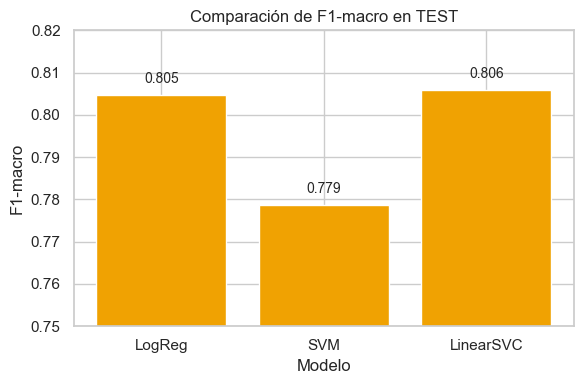

In [16]:
scores = {
    "LogReg":    0.8048,
    "SVM":       0.7787,
    "LinearSVC": 0.8060
}

models     = list(scores.keys())
f1_values  = list(scores.values())

plt.figure(figsize=(6, 4))
bars = plt.bar(models, f1_values, color="#f0a202")  

plt.ylim(0.75, 0.82)
plt.ylabel("F1-macro")
plt.xlabel("Modelo")
plt.title("Comparación de F1-macro en TEST")

# etiquetas encima de cada barra
for bar, value in zip(bars, f1_values):
    plt.text(bar.get_x() + bar.get_width()/2,
             value + 0.002,
             f"{value:.3f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### Validación y selección

* **Cross-validation estratificada por grupos (`asin`)** – 5 folds  
  *F1-macro CV = 0 .803 ± 0 .007* → estimación sin fuga de información entre reseñas del mismo juego.
* **GridSearchCV** (30 ajustes) halló los hiper-parámetros óptimos:  

  | Parámetro | Valor |
  |-----------|------:|
  | `tfidf__max_features` | **60 000** |
  | `svc__C`              | **0.5** |

  Regularización más fuerte (C ↓) y vocabulario compacto → menor sobre-ajuste y tiempos razonables.

---

### Conclusiones finales

1. **Modelo ganador**: `TF-IDF(60 k) ➜ Linear SVC(C = 0.5)`  
   *F1-macro ≈ 0.81, accuracy ≈ 0.84* → buen equilibrio precisión/recuperación en un corpus desbalanceado.
2. **Cobertura negativa mejorada** – 78 % de las críticas “malas” se identifican correctamente; crucial para moderación o alertas de producto.

